[[[188 137  96]
  [187 137  96]
  [187 138  94]
  ..., 
  [170 120  79]
  [169 122  82]
  [176 127  85]]

 [[189 138  98]
  [188 137  96]
  [186 137  94]
  ..., 
  [173 121  81]
  [170 122  82]
  [176 127  83]]

 [[189 138  98]
  [190 137  97]
  [189 137  97]
  ..., 
  [179 124  86]
  [174 125  87]
  [176 127  85]]

 ..., 
 [[231 208 168]
  [231 208 167]
  [231 209 168]
  ..., 
  [105  91  76]
  [101  85  71]
  [103  86  69]]

 [[231 206 169]
  [231 208 168]
  [231 209 168]
  ..., 
  [186 171 150]
  [170 155 133]
  [186 170 147]]

 [[232 207 171]
  [232 208 168]
  [233 210 169]
  ..., 
  [175 159 135]
  [151 137 113]
  [171 157 132]]]


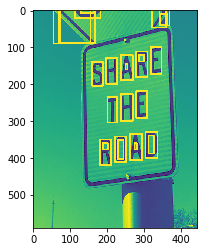

[[[190 206 211]
  [189 206 211]
  [190 206 211]
  ..., 
  [250 225 181]
  [245 221 181]
  [222 222 222]]

 [[190 206 212]
  [190 206 212]
  [191 206 213]
  ..., 
  [251 225 181]
  [245 221 181]
  [222 222 222]]

 [[189 205 212]
  [189 205 212]
  [190 206 213]
  ..., 
  [251 225 181]
  [245 221 181]
  [222 222 222]]

 ..., 
 [[170 205 238]
  [171 206 240]
  [173 209 242]
  ..., 
  [136 153 161]
  [146 161 169]
  [222 222 222]]

 [[173 208 241]
  [172 208 241]
  [173 209 242]
  ..., 
  [138 153 160]
  [148 161 169]
  [222 222 222]]

 [[172 207 241]
  [170 206 240]
  [173 208 241]
  ..., 
  [137 150 156]
  [147 158 165]
  [222 222 222]]]


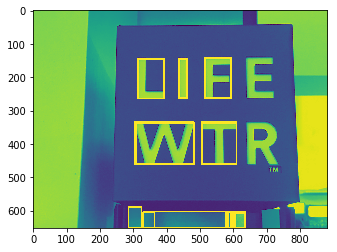

[[[ 86 102 107]
  [ 86 100 106]
  [ 87 102 108]
  ..., 
  [ 96 108 107]
  [ 89 100 101]
  [ 91 101 102]]

 [[ 88 104 109]
  [ 88 103 108]
  [ 92 107 112]
  ..., 
  [ 98 110 109]
  [ 90 102 102]
  [ 81  93  94]]

 [[ 87 103 108]
  [ 89 104 109]
  [ 90 104 109]
  ..., 
  [ 94 106 106]
  [ 87 100 100]
  [ 79  91  91]]

 ..., 
 [[124 124 105]
  [122 122 103]
  [120 120 100]
  ..., 
  [ 69  80  80]
  [ 70  82  81]
  [ 70  82  81]]

 [[123 123 104]
  [124 124 105]
  [122 123 103]
  ..., 
  [ 73  84  84]
  [ 68  79  77]
  [ 64  76  74]]

 [[122 122 102]
  [123 123 104]
  [122 124 104]
  ..., 
  [ 69  81  81]
  [ 69  81  79]
  [ 69  81  79]]]


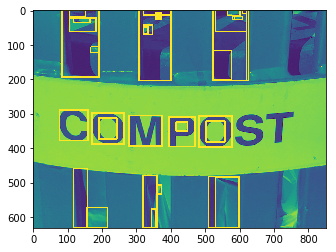

[[[156 190 212]
  [154 188 210]
  [153 186 209]
  ..., 
  [118 143 163]
  [120 144 165]
  [117 142 164]]

 [[154 188 209]
  [153 186 208]
  [152 186 208]
  ..., 
  [117 144 162]
  [117 143 163]
  [115 140 163]]

 [[155 188 210]
  [153 186 208]
  [153 187 209]
  ..., 
  [114 142 160]
  [113 140 160]
  [114 139 163]]

 ..., 
 [[149 188 221]
  [147 187 218]
  [145 186 218]
  ..., 
  [133 174 207]
  [133 175 207]
  [135 176 208]]

 [[147 188 220]
  [147 187 219]
  [146 186 219]
  ..., 
  [134 174 207]
  [132 174 206]
  [133 174 206]]

 [[146 187 220]
  [146 186 219]
  [146 186 219]
  ..., 
  [134 175 209]
  [133 174 208]
  [133 174 207]]]


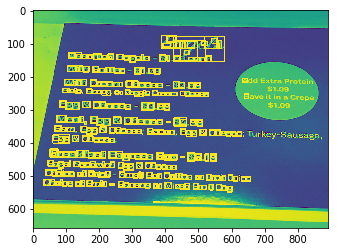

[[[ 76 105 182]
  [ 75 104 181]
  [ 77 106 183]
  ..., 
  [ 92 137 232]
  [ 95 138 232]
  [ 95 139 231]]

 [[ 75 104 181]
  [ 74 103 180]
  [ 92 121 197]
  ..., 
  [ 93 137 233]
  [ 93 138 231]
  [ 93 138 231]]

 [[ 77 105 183]
  [ 89 116 193]
  [ 96 125 201]
  ..., 
  [ 93 137 232]
  [ 92 137 231]
  [ 93 138 231]]

 ..., 
 [[134 180 236]
  [126 172 230]
  [131 175 239]
  ..., 
  [ 90 115 174]
  [ 92 117 176]
  [ 93 118 176]]

 [[104 139 220]
  [ 94 129 214]
  [ 91 125 212]
  ..., 
  [ 83 110 167]
  [ 84 110 167]
  [ 88 113 171]]

 [[ 80 111 202]
  [ 81 112 202]
  [ 84 116 203]
  ..., 
  [ 86 112 171]
  [ 86 111 169]
  [ 87 111 170]]]


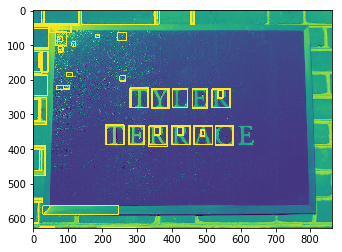

[[[ 99 111 113]
  [102 114 116]
  [107 118 122]
  ..., 
  [179 189 196]
  [181 189 196]
  [182 190 197]]

 [[ 97 109 111]
  [101 113 115]
  [106 117 121]
  ..., 
  [181 191 198]
  [184 192 199]
  [184 192 199]]

 [[100 111 115]
  [101 112 116]
  [103 114 118]
  ..., 
  [181 191 198]
  [183 191 198]
  [183 191 198]]

 ..., 
 [[141 153 165]
  [144 156 168]
  [150 159 172]
  ..., 
  [190 200 208]
  [190 200 207]
  [190 200 207]]

 [[147 156 169]
  [149 158 171]
  [151 160 173]
  ..., 
  [191 201 208]
  [191 201 208]
  [190 200 207]]

 [[149 158 171]
  [152 161 174]
  [154 163 176]
  ..., 
  [191 201 208]
  [191 201 208]
  [190 200 207]]]


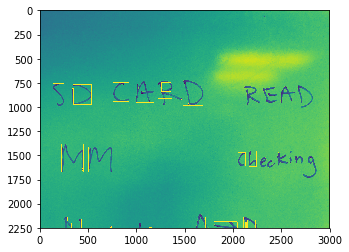

In [177]:
import matplotlib
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

def auto_canny(img, sigma=0.33):
    median = np.median(img)
    lower = int(max(0, (1 - sigma)* sigma))
    upper = int(min(255, (1 + sigma)* sigma))

    return cv2.Canny(img, lower, upper)


mser = cv2.MSER_create()
image_letters = []
for i in range(1,7):
    image_letters.append([])
    img = cv2.imread('image' + str(i) + '.png')
    print(img)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    vis = img_gray.copy()
    # vis = cv2.Canny(img_gray, 30, 200)
    # plt.imshow(vis)
    # plt.show()
    img_gray = cv2.GaussianBlur(img_gray, (3,3), 0)
    # regions = mser.detectRegions(vis)
    regions, _ = mser.detectRegions(img_gray)
    # i = 1
    for region in regions:

        region = np.array(region)
        minX = np.min(region[:, 0])
        maxX = np.max(region[:, 0])
        highestY = np.min(region[:, 1])
        lowestY = np.max(region[:, 1])
        
        if min([minX,maxX,highestY,lowestY]) < 0 or max([minX,maxX]) > img.shape[0] or max([highestY,lowestY]) > img.shape[1]:
            continue

        image_letters[-1].append((None, minX, lowestY, maxX, highestY))

        cv2.rectangle(vis, (maxX, lowestY), (minX, highestY), (255, 0, 0), 2)

    # hulls = [cv2.convexHull(p.reshape(-1, 1, 2)) for p in regions]

    plt.imshow(vis)
    plt.show()

images_folder = 'images_cropped'
if not os.path.exists(images_folder):
    os.mkdir(images_folder)
image_paths = []
for i,letters in enumerate(image_letters, 1):
    image_file = 'image' + str(i) + '.png'
    image_folder = 'image' + str(i)
    img = cv2.imread(image_file)
    if not os.path.exists(os.path.join(images_folder,image_folder)):
        os.mkdir(os.path.join(images_folder,image_folder))
    for j,letter in enumerate(letters):
#         plt.imshow(img[letter[1]:letter[3],letter[2]:letter[4]])
#         plt.show()
        image_path = os.path.join(images_folder,image_folder,'image'+str(j)+'.png')
        image_paths.append(image_path)
        cv2.imwrite(image_path, img[letter[4]:letter[2],letter[1]:letter[3]])
        
with open('images.txt', 'w') as f:
    for path in image_paths:
        f.write(path+'\n')
    
with open('image_letter_positions.txt', 'w') as f:
    for letters in image_letters:
        f.write(str(letters)+'\n')

In [159]:
import torch


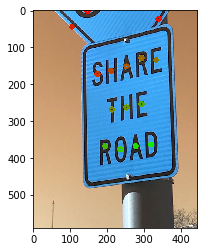

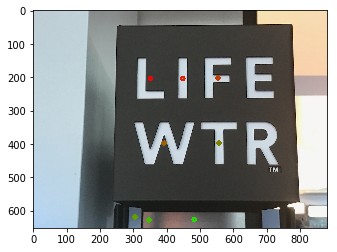

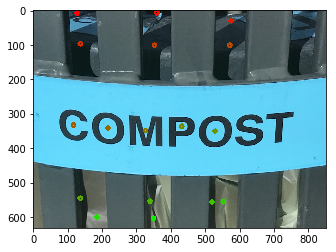

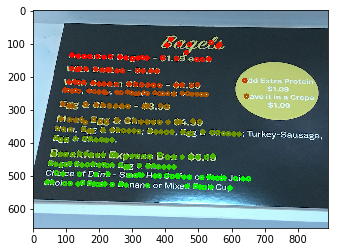

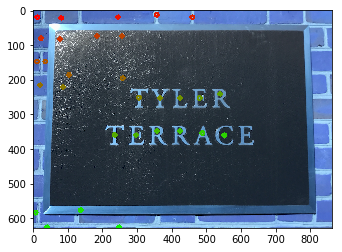

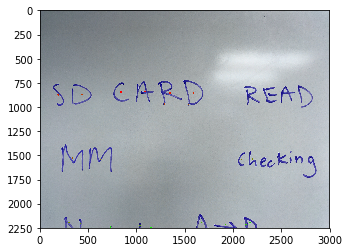

In [231]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
from sklearn.cluster import KMeans

class Word:
    def __init__(self):
        self.letters = []
        self.minx = None
        self.miny = None
        self.maxx = None
        self.maxy = None
        
    def append(self, letter):
        self.letters.append(letter)
        self.update_box()
        
    def update_box(self):
        self.minx = min([min(letter.x1,letter.x2) for letter in self.letters])
        self.miny = min([min(letter.y1,letter.y2) for letter in self.letters])
        self.maxx = max([max(letter.x1,letter.x2) for letter in self.letters])
        self.maxy = max([max(letter.y1,letter.y2) for letter in self.letters])
        
    def position(self):
        self.update_box()
        return [(self.minx + self.maxx)/2, (self.miny+self.maxy)/2]
    
    def add_letters(self, letters, mean, std):
        pass
    
    def __str__(self):
        final_string = ""
        for letter in self.letters:
            final_string += str(letter)
        return final_string
    
class Letter:
    def __init__(self, letter, p1x, p1y, p2x, p2y):
        self.letter = letter
        self.x1 = p1x
        self.y1 = p1y
        self.x2 = p2x
        self.y2 = p2y

    def size(self):
        return np.abs(self.x1-self.x2)*np.abs(self.y1-self.y2)

    def position(self):
        return [(self.x1+self.x2)/2, (self.y1+self.y2)/2]
    
    def __str__(self):
        return str(self.position()[0])

def grouper(iterable, threshold, function):
    iterable = sorted(iterable, key=function)
    prev = None
    group = []
    for item in iterable:
        if prev is None or function(item) - function(prev) <= threshold:
            group.append(item)
        else:
            yield group
            group = [item]
        prev = item
    if group:
        yield group

def choose_letter_distance_group(diff_groups):
    for i in range(len(diff_groups)):
        mean = np.mean(diff_groups[i])
        if i > 0:
            return i
        
def main(letters_file):
    words = []
    image_letters = []
    with open(letters_file, 'r') as f:
        for line in f:
            image_letters.append([Letter(*letter) for letter in eval(line)])
            
    for i,letters in enumerate(image_letters):
        words.append([])
        sizes = np.array([l.size() for l in letters])
        y_positions = np.array([l.position()[1] for i,l in enumerate(letters)])
        lines = dict(enumerate(grouper(letters, 10, lambda l:l.position()[1])))
#         plt.hist(y_positions, 25)
#         plt.show()
#         print(lines)
        for line in lines.values():
            x_positions = [l.position()[0] for l in line]
            diff = [np.abs(x-y) for x, y in itertools.combinations(x_positions, 2)]
#             plt.hist(diff, 100)
#             plt.show()
            
            diff_groups = dict(enumerate(grouper(diff, 5, lambda x:x)))
            i = choose_letter_distance_group(diff_groups)
#             print(len(diff_groups))
            if i is None:
                continue
            mean = np.mean(diff_groups[i])
            std = np.std(diff_groups[i])
#             print(mean, std)
            horizontal_cursor = 0
            line = sorted(line, key=lambda x:x.position()[0])
            for letter in line:
#                 print(letter.position()[0], horizontal_cursor)
                if letter.position()[0] > horizontal_cursor:
                    words[-1].append(Word())
                    words[-1][-1].append(letter)
                    words[-1][-1].add_letters(letters, mean, std)
                    horizontal_cursor = words[-1][-1].maxx;
    for i,image_words in enumerate(words,1):
        img = cv2.imread('image'+str(i)+'.png')
        for j,word in enumerate(image_words):
            color = (255 - int(255*(float(j)/len(image_words))),int(255*(float(j)/len(image_words))),0)
            for letter in word.letters:
                x, y = letter.position()
                cv2.circle(img,(int(x),int(y)),5,color,5)
        plt.imshow(img)
        plt.show()
    
    
if __name__ == '__main__':
    main('image_letter_positions.txt')